In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image, ImageEnhance
import json
from utils import *
import math
import numpy as np
import matplotlib.colors as mcolors
from scipy.spatial import KDTree
from helper_code.graph_reconstruction import *
from helper_code.mask_detection import *
from helper_code.metadata_extraction import *
from helper_code.color_detection import *
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)

In [2]:
def get_all_color_names():
    css3_db = CSS3_HEX_TO_NAMES
    color_names = []
    color_rgb_values = []
    for color_hex, color_name in css3_db.items():
        color_names.append(color_name)
        color_rgb_values.append(hex_to_rgb(color_hex))
    return color_names, color_rgb_values

In [3]:
COLOR_NAMES, COLOR_RGB_VALUES = get_all_color_names()
KDT_DB = KDTree(COLOR_RGB_VALUES)

In [4]:
def convert_rgb_to_names(rgb_tuple, memo):
    distance, index = KDT_DB.query(rgb_tuple)

    # print(f'closest match: {COLOR_NAMES[index]}')

    simple_color = complex_to_simple_color[COLOR_NAMES[index]]
    memo[simple_color] = memo.get(simple_color, 0) + 1
    return simple_color

In [5]:
# def rgb_to_simple_color(rgb):
#     """
#     Maps an RGB color to a simple color (red, orange, yellow, green, blue, purple, pink, grey, black, white).

#     :param rgb: A tuple (R, G, B) representing the RGB values.
#     :return: A string representing the simple color.
#     """
#     # Define RGB values for simple colors
#     simple_colors = {
#         "red": (255, 0, 0),
#         "orange": (255, 165, 0),
#         "yellow": (255, 255, 0),
#         "green": (0, 128, 0),
#         "blue": (0, 0, 255),
#         "purple": (128, 0, 128),
#         "pink": (255, 192, 203),
#         "grey": (128, 128, 128),
#         "black": (0, 0, 0),
#         "white": (255, 255, 255)
#     }

#     def color_distance(c1, c2):
#         """Calculate the Euclidean distance between two colors."""
#         return math.sqrt(sum([(a - b) ** 2 for a, b in zip(c1, c2)]))

#     # Check for special cases of black, white, and grey
#     if all(x < 50 for x in rgb):  # Arbitrarily chosen threshold for black
#         return "black"
#     if all(x > 200 for x in rgb):  # Arbitrarily chosen threshold for white
#         return "white"
#     if max(rgb) - min(rgb) < 30:  # Threshold for grey, based on low variance in RGB values
#         return "grey"

#     # Find the closest simple color
#     closest_color = min(simple_colors, key=lambda color: color_distance(rgb, simple_colors[color]))
#     return closest_color

# # Map each color to a simple color
# simple_color_mapping = {color: rgb_to_simple_color(rgb) for color, rgb in zip(COLOR_NAMES, COLOR_RGB_VALUES)}

In [6]:
def get_color_masks(image_name, rgb_colors):
    image = Image.open(image_name)
    image = image.convert('RGB')
    # filter = ImageEnhance.Contrast(image)
    # image = filter.enhance(2)

    width, height = image.size
    masks = {}
    for c in rgb_colors:
        masks[c] = np.zeros((width, height))
    
    memo = {}
    for y in range(0, height):
        for x in range(0, width):

            r, g, b = image.getpixel((x, y))

            new_color = convert_rgb_to_names([r,g,b], memo)

            if new_color in rgb_colors:
                masks[new_color][x, y] = 1
                
    return masks, width, height, memo

In [7]:
## COLOR DETECTION

def get_points_new(color_masks, width, height, boundingBox, color, wBox, hBox, x_axis, y_axis):

    graph = []
    mask = color_masks[color]

    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):
            
            x, y = get_middle_coordinate(x0, y0, wBox, hBox)
            value = get_filtered_answer(mask, x0, y0, wBox, hBox, boundingBox["bottomRight"][0], boundingBox["bottomRight"][1])

            if value: 
                graph.append({
                "topLeft": (x0, y0), 
                "middle": convertPoint((x,y), boundingBox, width, height, x_axis, y_axis), 
                })
    
    return graph

In [8]:
## HELPER FUNCTION
def is_valid_color(color):
    try:
        mcolors.to_rgba(color)
        return True
    except ValueError:
        return False

In [9]:
def do_analysis(image_number, predictor):
    image_name = '../plot_images/'+str(image_number)+'.png'
    image = cv2.imread(image_name)

    height, width = image.shape[:2]
    input_point = np.array([[width // 2 - 50, height // 2 - 50], [width // 2 - 50, height // 2 + 50], [width // 2 + 50, height // 2 - 50], [width // 2 + 50, height // 2 + 50]])
    input_label = np.array([1, 1, 1, 1])

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
    main_mask, main_mask_score = get_main_mask(masks, scores)

    n_image = image.copy()
    new_image, boundingBox = get_bounding_box(main_mask, n_image)

    points = np.array([
        boundingBox["topLeft"], 
        [boundingBox["topLeft"][0], boundingBox["bottomRight"][1]], 
        [boundingBox["bottomRight"][0], boundingBox["topLeft"][1]], 
        boundingBox["bottomRight"]
    ])
    
    return image_name, boundingBox

In [10]:
def do_complete_analysis(wBox, hBox, metadata, image_name, boundingBox, onlyColorsInImage = False, distance_type = "euclidean"):

    x_axis = metadata["x-axis"]["range"]
    y_axis = metadata["y-axis"]["range"]
    x_axis_title = metadata["x-axis"]["title"]
    y_axis_title = metadata["y-axis"]["title"]

    axis_labels = []
    rgb_colors = []
    coordinates = []
    for label, color in metadata["types"]:
        axis_labels.append(label)
        rgb_colors.append(color)
    
    color_masks, width, height, memo = get_color_masks(image_name, rgb_colors)

    print("This image has the following colors", memo)

    for color in rgb_colors:
        coordinates.append(get_points_new(color_masks, width, height, boundingBox, color, wBox, hBox, x_axis, y_axis))

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_axis, y_axis, memo

In [11]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

IMAGE NUMBER 1


This image has the following colors {'white': 136126, 'grey': 6835, 'blue': 1569, 'black': 1079, 'gray': 14, 'purple': 816, 'green': 5, 'pink': 692}


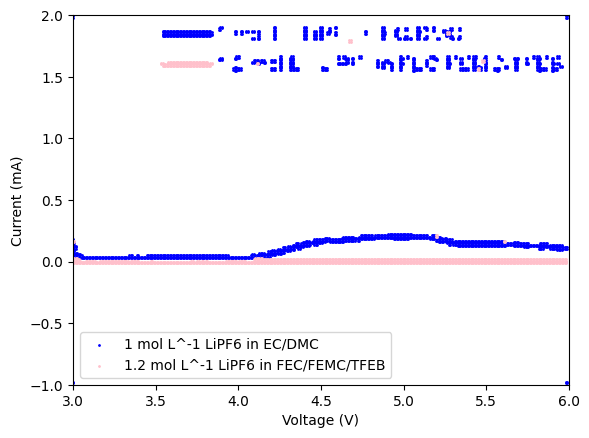

IMAGE NUMBER 2
This image has the following colors {'white': 127356, 'grey': 10034, 'blue': 2395, 'black': 180, 'pink': 991, 'gray': 52, 'green': 104, 'orange': 76, 'red': 29, 'purple': 1735}


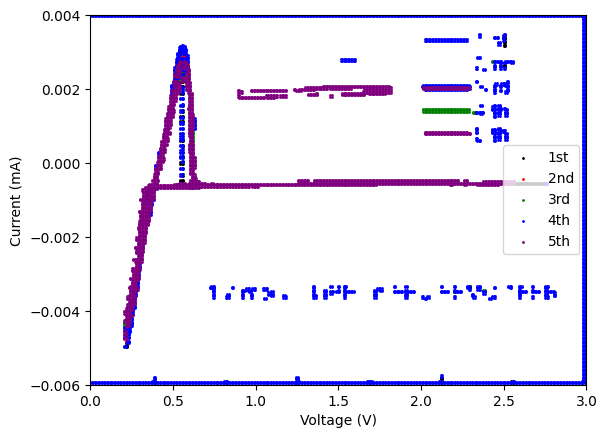

IMAGE NUMBER 3
This image has the following colors {'white': 127163, 'grey': 7695, 'blue': 1302, 'black': 1048, 'pink': 1267, 'orange': 63, 'green': 124, 'gray': 19, 'yellow': 2, 'purple': 2148, 'red': 1}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


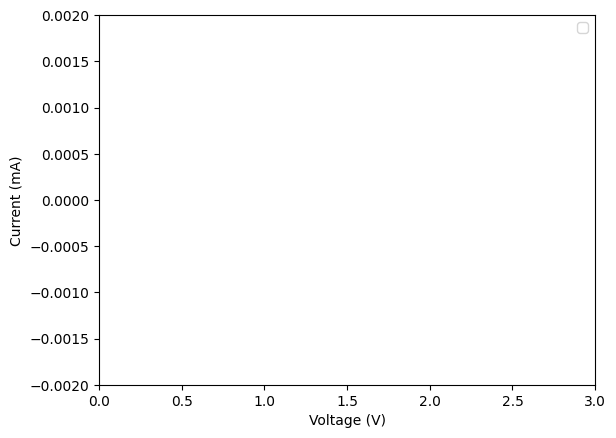

IMAGE NUMBER 4
This image has the following colors {'white': 116718, 'grey': 9894, 'blue': 3978, 'black': 640, 'orange': 776, 'pink': 1954, 'red': 114, 'purple': 3345, 'green': 2413, 'yellow': 96, 'gray': 252}


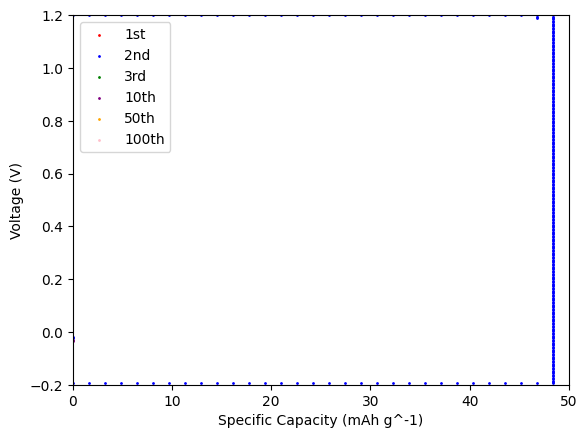

IMAGE NUMBER 5
This image has the following colors {'white': 120325, 'grey': 7477, 'blue': 5377, 'green': 76, 'pink': 1897, 'black': 613, 'gray': 102, 'orange': 21, 'purple': 1247, 'yellow': 9}


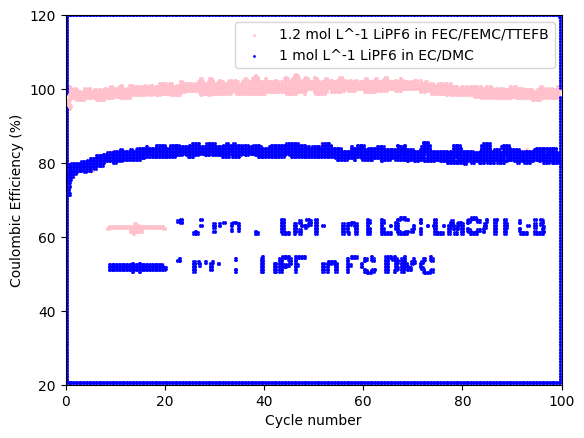

IMAGE NUMBER 6
This image has the following colors {'white': 110572, 'grey': 11039, 'blue': 2291, 'gray': 333, 'pink': 1137, 'black': 1166, 'orange': 592, 'red': 153, 'green': 2870, 'purple': 2974, 'yellow': 225}


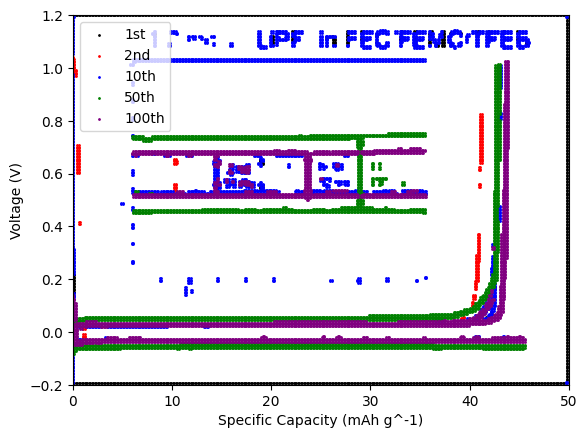

IMAGE NUMBER 7
This image has the following colors {'white': 283660, 'grey': 23729, 'blue': 9061, 'black': 247, 'gray': 143, 'green': 2843, 'yellow': 316, 'orange': 990, 'purple': 120, 'pink': 4455}


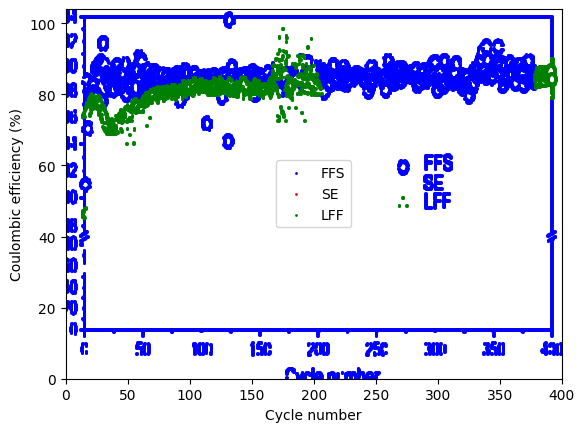

IMAGE NUMBER 8
This image has the following colors {'white': 151635, 'grey': 10173, 'blue': 2525, 'black': 229, 'yellow': 460, 'orange': 1093, 'green': 4150, 'purple': 2694, 'pink': 21, 'gray': 20}


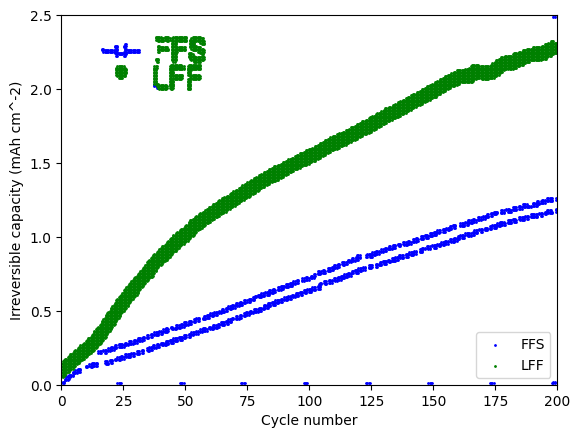

IMAGE NUMBER 9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This image has the following colors {'white': 127442, 'grey': 17472, 'blue': 3237, 'black': 446, 'purple': 525, 'gray': 251, 'pink': 1826, 'green': 1497, 'orange': 5035, 'yellow': 2293}


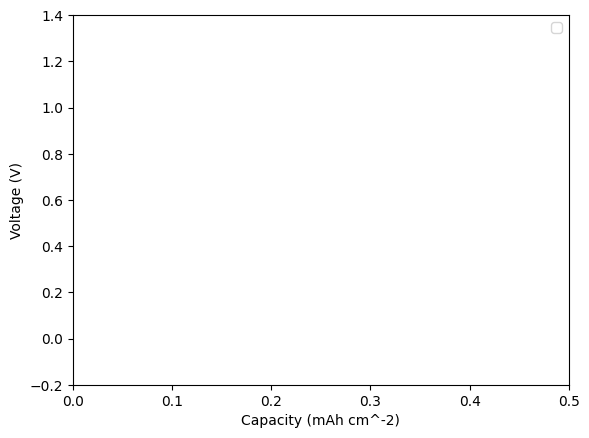

IMAGE NUMBER 10
This image has the following colors {'white': 134407, 'grey': 7747, 'blue': 1730, 'black': 136, 'yellow': 431, 'orange': 4359, 'green': 340, 'pink': 26986, 'purple': 10467, 'gray': 885}


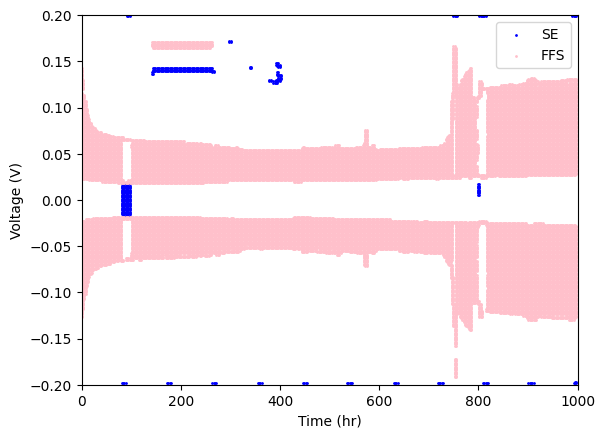

IMAGE NUMBER 11


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt

for image_num in range(1, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num, predictor)

    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, False)

    plt.figure()
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])

        color_normalized = rgb_colors[index]

        if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()
    plt.show()

    